In [13]:
import argparse
import itertools as it
import os
from tqdm import tqdm
import torch
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import cv2
from collections import namedtuple
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from collections import defaultdict
from PIL import Image
import math
import random
import pickle
import sys

import torch
from torch.utils import data
from torch.utils.data.dataloader import default_collate
from torch.autograd import Variable
import torchvision
import torchvision.transforms as transforms

try:
    from kornia.augmentation import *
except:
    print("Error importing kornia augmentation")

root_dir = os.getcwd()
os.chdir('/scratch/ainaz/omnidata2')
from models.unet import UNet


os.chdir('/scratch/sasha/')
sys.path.insert(1, '/scratch/sasha/')
import soda as tta

os.chdir('/scratch/sasha/omnidata/')
from transform_params import ALL_TRANSFORMS

os.chdir(root_dir)


Error importing kornia augmentation


In [14]:
class OASISNormalDataset(data.Dataset):
    def __init__(self, csv_filename, data_aug=False, img_size=256):
        super(OASISNormalDataset, self).__init__()
        print("=====================================================")
        print("Using OASISNormalDataset...")
        print("csv file name: %s" % csv_filename)

        img_names = []
        normal_names = []

        with open(csv_filename) as infile:
            next(infile) # skip header
            for line in infile:
                # Filenames are absolute directories
                img_name,_,_,normal_name,_,_,_,_,_,_,_,_,_,_ = line.split(',')
                if len(normal_name) == 0:
                    continue
                img_names.append(os.path.join('/scratch/ainaz', img_name.strip()))
                normal_names.append(os.path.join('/scratch/ainaz', normal_name.strip()))
    
        self.img_names = img_names
        self.normal_names = normal_names
        self.width = img_size #320
        self.height = img_size #240
        self.n_sample = len(self.img_names)

        self.data_aug = data_aug
        print("Network input width = %d, height = %d" % (self.width, self.height))
        print("%d samples" % (self.n_sample))
        print("Data augmentation: {}".format(self.data_aug))
        print("=====================================================")

    def __getitem__(self, index):
        color = cv2.imread(self.img_names[index]).astype(np.float32)
        normal_file = open(self.normal_names[index], 'rb')
        normal_dict = pickle.load(normal_file)


        h,w,c = color.shape
        mask = np.zeros((h,w))
        normal = np.zeros((h,w,c))

        # Stuff ROI normal into bounding box
        min_y = normal_dict['min_y']
        max_y = normal_dict['max_y']
        min_x = normal_dict['min_x']
        max_x = normal_dict['max_x']
        roi_normal = normal_dict['normal']
        try:
            normal[min_y:max_y+1, min_x:max_x+1, :] = roi_normal
            normal = normal.astype(np.float32)
        except Exception as e:
            print("Error:", self.normal_names[index])
            print(str(e))
            return 

        # Make mask
        roi_mask = np.logical_or(np.logical_or(roi_normal[:,:,0] != 0, roi_normal[:,:,1] != 0), roi_normal[:,:,2] != 0).astype(np.float32)

        mask[min_y:max_y+1, min_x:max_x+1] = roi_mask


        orig_height = color.shape[0]
        orig_width = color.shape[1]
        # Downsample training images
        color = cv2.resize(color, (self.width, self.height))
        mask = cv2.resize(mask, (self.width, self.height))
        normal = cv2.resize(normal, (self.width, self.height))

        # Data augmentation: randomly flip left to right
        if self.data_aug:
            if random.random() < 0.5:
                color = cv2.flip(color, 1)
                normal = cv2.flip(normal, 1)
                # make sure x coordinates of each vector get flipped
                normal[:,:,0] *= -1

        color = np.transpose(color, (2, 0, 1)) / 255.0  # HWC to CHW.
        normal = np.transpose(normal, (2, 0, 1))   # HWC to CHW.
        # Add one channel b/c Pytorch interpolation requires 4D tensor
        mask = mask[np.newaxis, :, :]

        return color, normal, mask, (orig_height, orig_width)

    def __len__(self):
        return self.n_sample


class OASISNormalDatasetVal(OASISNormalDataset):
    def __init__(self, csv_filename, data_aug=False, short_side_size=512, long_side_size=None):
        print("+++++++++++++++++++++++++++++++++++++++++++++++")
        print("Using OASISNormalDatasetVal...")
        print("csv file name: %s" % csv_filename)
        OASISNormalDataset.__init__(self, csv_filename, data_aug=data_aug)
        self.short_side_size = short_side_size
        self.long_side_size = long_side_size

    def __getitem__(self, index):
#         color = cv2.imread(self.img_names[index]).astype(np.float32)
        color = np.array(Image.open(self.img_names[index])).astype(np.float32) # my code
        normal_file = open(self.normal_names[index], 'rb')
        normal_dict = pickle.load(normal_file)
        
        if len(color.shape) < 3:
            print("://")
            color = np.expand_dims(color, axis=2)
            color = np.repeat(color, 3, axis=2)

        h,w,c = color.shape
        mask = np.zeros((h,w))
        normal = np.zeros((h,w,c))

        # Stuff ROI normal into bounding box
        min_y = normal_dict['min_y']
        max_y = normal_dict['max_y']
        min_x = normal_dict['min_x']
        max_x = normal_dict['max_x']
        roi_normal = normal_dict['normal']
        try:
            normal[min_y:max_y+1, min_x:max_x+1, :] = roi_normal
            normal = normal.astype(np.float32)
        except Exception as e:
            print("Error:", self.normal_names[index])
            print(str(e))
            return 

        # Make mask
        roi_mask = np.logical_or(np.logical_or(roi_normal[:,:,0] != 0, roi_normal[:,:,1] != 0), roi_normal[:,:,2] != 0).astype(np.float32)

        mask[min_y:max_y+1, min_x:max_x+1] = roi_mask

        orig_height = color.shape[0]
        orig_width = color.shape[1]

        if orig_width > orig_height:
            self.height, self.width = self.short_side_size, int(self.short_side_size * orig_width / orig_height)
            if self.long_side_size is not None:
                self.width = self.long_side_size
        else:
            self.height, self.width = int(self.short_side_size * orig_height / orig_width), self.short_side_size
            if self.long_side_size is not None:
                self.height = self.long_side_size
        ####################
  
        # Downsample training images
        color = cv2.resize(color, (self.width, self.height))
        color = np.transpose(color, (2, 0, 1)) / 255.0  # HWC to CHW.
        normal = np.transpose(normal, (2, 0, 1))   # HWC to CHW.
        
        # Add one channel b/c Pytorch interpolation requires 4D tensor
        mask = mask[np.newaxis, :, :]

        return color, normal, mask, (orig_height, orig_width), self.img_names[index]

    def __len__(self):
        return self.n_sample

In [15]:
def valid_normals(model, type, coord_change, data_loader, max_iter, verbal, front_facing = False, b_vis_normal = False, 
                  use_fixed_input_size=None, fixed_input_width=512, fixed_input_height=512):
    def angle_error(preds, truths):
        '''
        preds and truths: Nx3 pytorch tensor
        '''
        preds_norm =  torch.nn.functional.normalize(preds, p=2, dim=1)
        truths_norm = torch.nn.functional.normalize(truths, p=2, dim=1)
        angles = torch.sum(preds_norm * truths_norm, dim=1)
                
        # Clip values so that max is 1 and min is -1, but don't change intermediate values
        angles = torch.clamp(angles, -1, 1)
        angles = torch.acos(angles)
        return angles

    # In degrees
    def mean(errors):
        error_sum = 0
        total_pixels = 0
        for matrix in errors:
            error_sum += np.sum(matrix)
            total_pixels += matrix.size
        return math.degrees(error_sum / total_pixels)

    # In degrees
    def median(errors):
        return math.degrees(np.median(np.concatenate(errors)))
  
    # 11.25, 22.5, 30
    def below_threshold(errors, thresh_angle):
        num = 0
        total_pixels = 0
        for matrix in errors:
            num += np.sum(matrix < math.radians(thresh_angle))
            total_pixels += matrix.size
        return num / total_pixels

  
    print("####################################")
    print("Evaluating...")
    print("\tfront_facing = %s"  %  front_facing)
    print("\tuse_fixed_input_size = %s"  %  use_fixed_input_size)
    print(f"\tsize = ({fixed_input_height}, {fixed_input_width})")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    iter = 0
    with torch.no_grad():
        errors = []
        for step, data_tuple in tqdm(enumerate(data_loader), total=max_iter):
            if len(data_tuple) == 3:
                inputs, targets, target_res = data_tuple
            elif len(data_tuple) == 5:
                inputs, targets, masks, target_res, _ = data_tuple
                masks = masks.to(device)
            iter += 1
            if iter < 10:
                print(inputs.shape)
            if iter > max_iter:
                break

            input_var = Variable(inputs.to(device))
            if use_fixed_input_size:
                size = (fixed_input_height, fixed_input_width) #(512, 640) #
                input_var = torch.nn.functional.interpolate(input_var, size=size, mode='bilinear')

            output_var = model(input_var)

            targets = targets.to(device)

            orig_height = target_res[0]
            orig_width = target_res[1]
            output_var = torch.nn.functional.interpolate(output_var, size=(orig_height, orig_width), mode='bilinear')
            targets = torch.nn.functional.interpolate(targets, size=(orig_height, orig_width), mode='bilinear')
            masks = torch.nn.functional.interpolate(masks, size=(orig_height, orig_width), mode='bilinear')
            mask = masks.byte().squeeze(1) # remove color channel        
            output_var = torch.nn.functional.normalize(output_var, p=2, dim=1)
            output = output_var.permute(0,2,3,1)[mask, :]
            target = targets.permute(0,2,3,1)[mask, :]

            if front_facing :
                output[:,0] = 0 # output: torch.Size([N, 3])
                output[:,1] = 0
                output[:,2] = 1
                
            if iter < 50:
                output_var[:,2,:,:] *= -1
                vis = ((output_var.permute(0,2,3,1)[0,:,:,:].cpu().detach().numpy() + 1.0) / 2.0 * 255.0).astype(np.uint8)
                input_var = torch.nn.functional.interpolate(input_var, size=(orig_height, orig_width), mode='bilinear')
                rgb = input_var.cpu().detach().numpy()[0,:,:,:]
                rgb = (rgb.transpose(1, 2, 0) * 255).astype(np.uint8)
                im = np.concatenate([rgb, vis], axis=1)
                plt.imshow(im)
                plt.show()

        
            error = angle_error(output, target)

            errors.append(error.data.cpu().detach().numpy())


              
        MAE = mean(errors)
        print("Mean angle error: {} degs".format(MAE))
        below_1125 = below_threshold(errors, 11.25)
        print("% below 11.25 deg: {}".format(below_1125))
        below_225 = below_threshold(errors, 22.5)
        print("% below 22.5 deg: {}".format(below_225))
        below_30 = below_threshold(errors, 30)
        print("% below 30 deg: {}".format(below_30))
        MDAE = median(errors)
        print("Median angle error: {} degs".format(MDAE))
        sys.stdout.flush()

        results = {}
        results['MAE'] = MAE
        results['MDAE'] = MDAE
        results['11.25'] = below_1125
        results['22.5'] = below_225
        results['30'] = below_30
        return results



    
def valid(model, coord_change, data_loader, dataset_name, max_iter=1400, 
          verbal=False, b_vis_normal=False, in_thresh = None, front_facing = False, 
          use_fixed_input_size=None, fixed_input_width=512, fixed_input_height=512):
    print("Evaluation on {}".format(dataset_name))

    # NYU: x points left, y points down, z points toward us
    # SNOW: x points right, y points up, z points toward us
    # OASIS: x points right, y points down, z points toward us

    return valid_normals(model, 'OASIS', coord_change, data_loader, max_iter, verbal, front_facing, b_vis_normal,
        use_fixed_input_size=use_fixed_input_size, fixed_input_width=fixed_input_width, fixed_input_height=fixed_input_width)



In [16]:
def evaluate_normals(pretrained_weights_path, transforms, test_data_loader, num_iters=10000, normalize_output=True,
        use_fixed_input_size=None, fixed_input_width=512, fixed_input_height=512, name='Running dataset', return_model=False):
    with torch.no_grad():
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        model = UNet(in_channels=3, out_channels=3)
        checkpoint = torch.load(pretrained_weights_path, map_location='cuda:0')
        if 'state_dict' in checkpoint:
            state_dict = {}
            for k, v in checkpoint['state_dict'].items():
                state_dict[k.replace('model.', '')] = v
        else:
              state_dict = checkpoint
        model.load_state_dict(state_dict)
        model.to(device)
        model.eval().cuda()

        def model_fn(x):
            output_var = (model(x))* 2 - 1
            output_var[:,2,:,:] *= -1
            if normalize_output:
                output_var = torch.nn.functional.normalize(output_var, p=2, dim=1)
            return output_var

        wrapper = tta.SurfaceNormalsTTAWrapper(model=model_fn, transforms=transforms, run_mode='serial', merger_fn=tta.MedianMerger)
        wrapper_fn = lambda x: torch.nn.functional.normalize(wrapper(x), p=2, dim=1)

        print("\n\n")
        print(f'+----------------------------------+')
        print(f'|  OASISNormalDatasetVal ')
        print(f'+----------------------------------+')

        test_rel_error = valid(wrapper_fn, [1., 1., -1.], test_data_loader, dataset_name='OASISNormalDatasetVal', 
                                       max_iter = num_iters, in_thresh=0.0, b_vis_normal=True, 
                                       verbal=True, front_facing=False, 
                                       use_fixed_input_size=use_fixed_input_size, fixed_input_width=fixed_input_width, fixed_input_height=fixed_input_width)

        if return_model:
            return test_rel_error, checkpoint
        return test_rel_error
    
def load_data_and_evaluate(
   pretrained_weights_path, transforms,
   dataset_file='/scratch/ainaz/OASIS/OASIS_trainval/OASIS_val.csv', num_iters=10000,
   short_side_size=512, long_side_size=None, 
   use_fixed_input_size=None, fixed_input_width=512, fixed_input_height=512,
   return_model=False):
    test_dataset = OASISNormalDatasetVal(csv_filename = dataset_file,
        short_side_size=short_side_size, long_side_size=long_side_size)

    test_data_loader = data.DataLoader(test_dataset, batch_size=1, num_workers=1, shuffle=False, collate_fn = default_collate)
    
    result = evaluate_normals(pretrained_weights_path, transforms, test_data_loader, num_iters=num_iters, 
        use_fixed_input_size=use_fixed_input_size,
        fixed_input_width=fixed_input_width,
        fixed_input_height=fixed_input_width,
        return_model=return_model)
    return result

In [17]:
short_side_size = 640
long_side_size = 640
transform_name = 'tencrop_resize' 
use_fixed_input_size = False
fixed_input_height = 512
fixed_input_width = 512
# weights_file = '/scratch/sasha/omnidata/best_checkpoints/best_MAE_1k.pth'
weights_file = '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/34t8zd61/epoch=0-v0.ckpt'
# weights_file = '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/3i8uv0k8/epoch=14-v1.ckpt'
n_ims_to_eval = 1000

test_file = '/scratch/ainaz/OASIS/OASIS_trainval/OASIS_val.csv'
collate_fn = default_collate
DataSet = OASISNormalDatasetVal
dataset_name = 'OASISNormalDatasetVal'
test_dataset = DataSet(csv_filename=test_file, short_side_size=short_side_size, long_side_size=long_side_size)
test_data_loader = data.DataLoader(test_dataset, batch_size=1, num_workers=1, shuffle=False, collate_fn = collate_fn)

+++++++++++++++++++++++++++++++++++++++++++++++
Using OASISNormalDatasetVal...
csv file name: /scratch/ainaz/OASIS/OASIS_trainval/OASIS_val.csv
Using OASISNormalDataset...
csv file name: /scratch/ainaz/OASIS/OASIS_trainval/OASIS_val.csv
Network input width = 256, height = 256
10000 samples
Data augmentation: False


+++++++++++++++++++++++++++++++++++++++++++++++
Using OASISNormalDatasetVal...
csv file name: /scratch/ainaz/OASIS/OASIS_trainval/OASIS_val.csv
Using OASISNormalDataset...
csv file name: /scratch/ainaz/OASIS/OASIS_trainval/OASIS_val.csv
Network input width = 256, height = 256
10000 samples
Data augmentation: False



+----------------------------------+
|  OASISNormalDatasetVal 
+----------------------------------+
Evaluation on OASISNormalDatasetVal
####################################
Evaluating...
	front_facing = False
	use_fixed_input_size = False
	size = (512, 512)


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1, 3, 640, 640])


<ipython-input-15-a3b0a24606e5>:77: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  output = output_var.permute(0,2,3,1)[mask, :]
<ipython-input-15-a3b0a24606e5>:78: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  target = targets.permute(0,2,3,1)[mask, :]


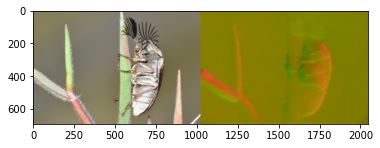

  0%|          | 1/1000 [00:03<1:05:15,  3.92s/it]

torch.Size([1, 3, 640, 640])


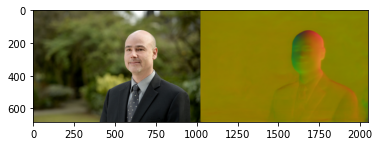

  0%|          | 2/1000 [00:07<1:02:44,  3.77s/it]

torch.Size([1, 3, 640, 640])


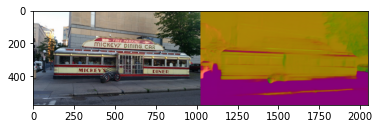

  0%|          | 3/1000 [00:10<1:00:16,  3.63s/it]

torch.Size([1, 3, 640, 640])


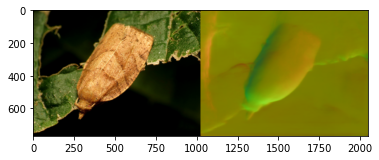

  0%|          | 4/1000 [00:14<59:00,  3.55s/it]  

torch.Size([1, 3, 640, 640])


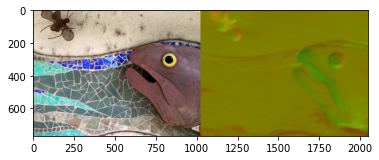

  0%|          | 5/1000 [00:17<57:28,  3.47s/it]

torch.Size([1, 3, 640, 640])


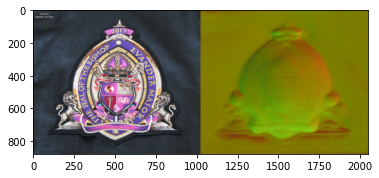

  1%|          | 6/1000 [00:20<57:15,  3.46s/it]

torch.Size([1, 3, 640, 640])


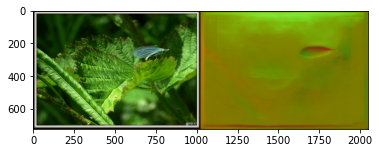

  1%|          | 7/1000 [00:24<57:18,  3.46s/it]

torch.Size([1, 3, 640, 640])


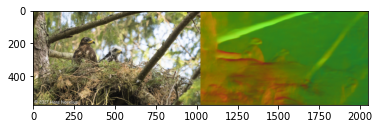

  1%|          | 8/1000 [00:27<57:04,  3.45s/it]

torch.Size([1, 3, 640, 640])


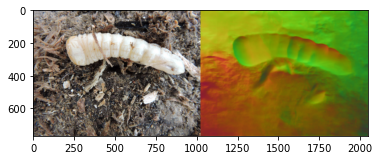

  1%|          | 9/1000 [00:31<57:03,  3.45s/it]

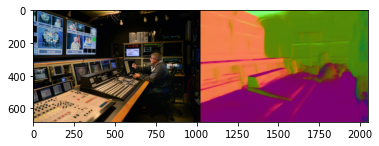

  1%|          | 10/1000 [00:34<57:17,  3.47s/it]

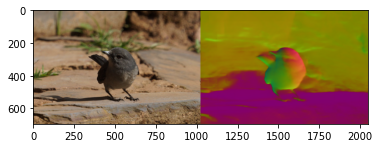

  1%|          | 11/1000 [00:38<56:58,  3.46s/it]

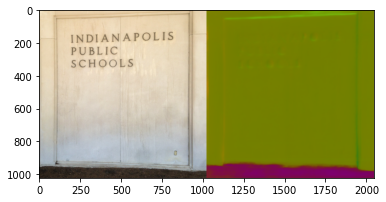

  1%|          | 12/1000 [00:41<57:21,  3.48s/it]

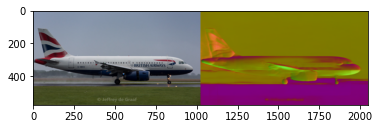

  1%|▏         | 13/1000 [00:44<56:02,  3.41s/it]

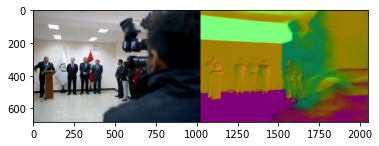

  1%|▏         | 14/1000 [00:48<55:17,  3.36s/it]

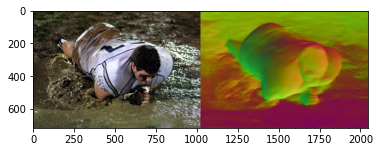

  2%|▏         | 15/1000 [00:51<55:20,  3.37s/it]

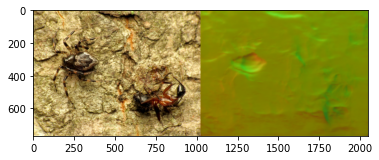

  2%|▏         | 16/1000 [00:54<55:43,  3.40s/it]

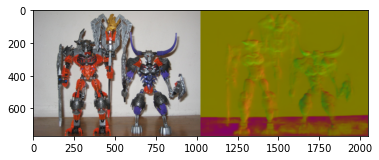

  2%|▏         | 17/1000 [00:58<55:45,  3.40s/it]

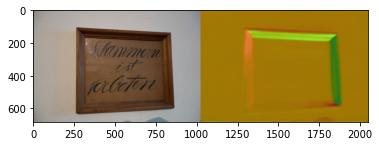

  2%|▏         | 18/1000 [01:01<55:38,  3.40s/it]

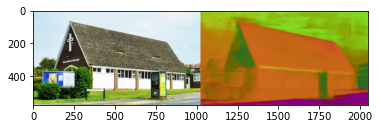

  2%|▏         | 19/1000 [01:05<56:04,  3.43s/it]

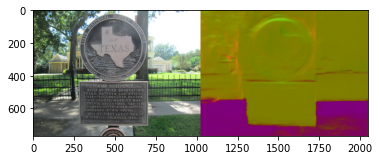

  2%|▏         | 20/1000 [01:08<55:35,  3.40s/it]

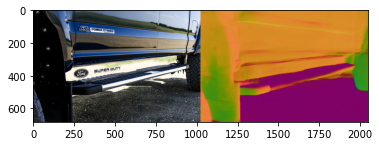

  2%|▏         | 21/1000 [01:12<55:49,  3.42s/it]

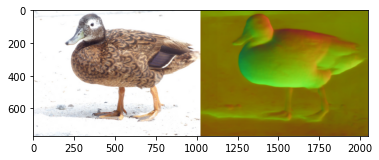

  2%|▏         | 22/1000 [01:15<56:37,  3.47s/it]

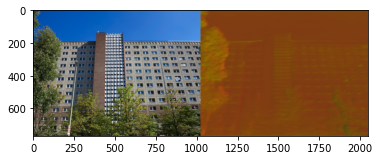

  2%|▏         | 23/1000 [01:18<55:46,  3.43s/it]

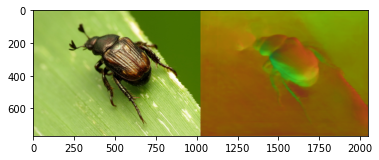

  2%|▏         | 24/1000 [01:22<55:51,  3.43s/it]

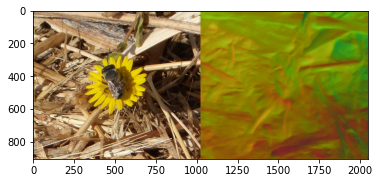

  2%|▎         | 25/1000 [01:25<56:28,  3.48s/it]

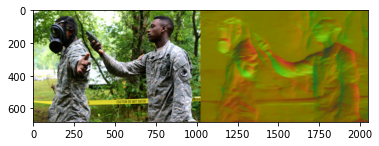

  3%|▎         | 26/1000 [01:29<55:07,  3.40s/it]

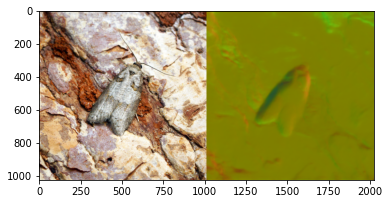

  3%|▎         | 27/1000 [01:32<54:51,  3.38s/it]

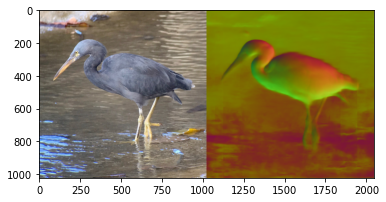

  3%|▎         | 28/1000 [01:35<55:12,  3.41s/it]

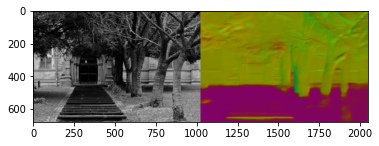

  3%|▎         | 29/1000 [01:39<55:25,  3.42s/it]

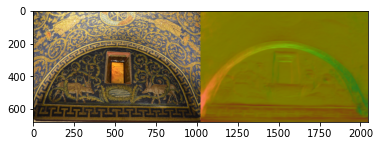

  3%|▎         | 30/1000 [01:42<54:18,  3.36s/it]

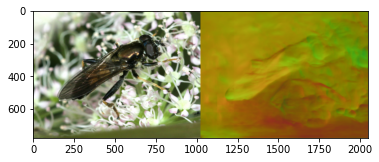

  3%|▎         | 31/1000 [01:45<54:04,  3.35s/it]

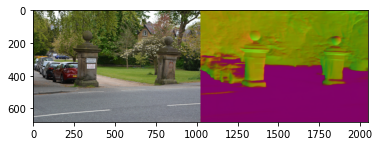

  3%|▎         | 32/1000 [01:49<54:21,  3.37s/it]

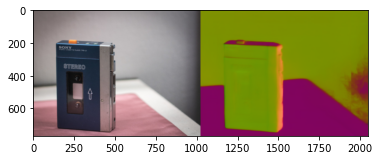

  3%|▎         | 33/1000 [01:52<54:58,  3.41s/it]

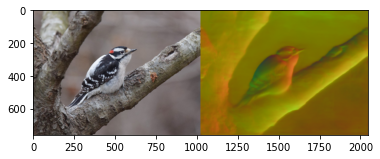

  3%|▎         | 34/1000 [01:56<55:10,  3.43s/it]

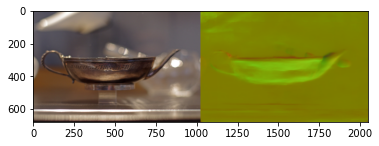

  4%|▎         | 35/1000 [01:59<54:58,  3.42s/it]

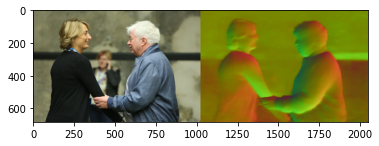

  4%|▎         | 36/1000 [02:03<55:02,  3.43s/it]

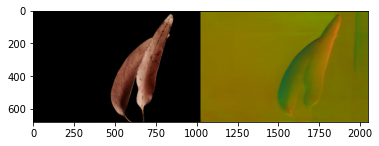

  4%|▎         | 37/1000 [02:06<54:10,  3.38s/it]

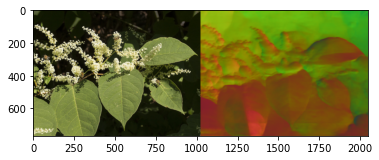

  4%|▍         | 38/1000 [02:09<54:34,  3.40s/it]

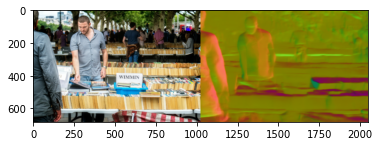

  4%|▍         | 39/1000 [02:13<54:19,  3.39s/it]

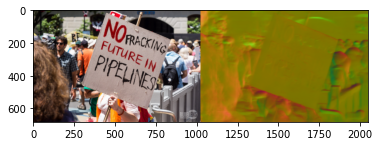

  4%|▍         | 40/1000 [02:16<54:30,  3.41s/it]

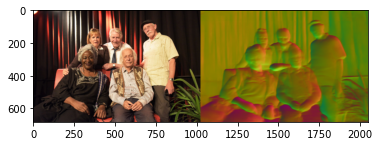

  4%|▍         | 41/1000 [02:20<54:01,  3.38s/it]

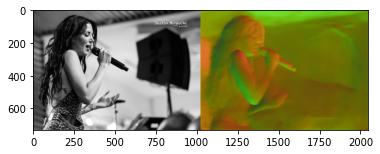

  4%|▍         | 42/1000 [02:23<54:29,  3.41s/it]

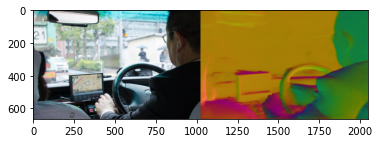

  4%|▍         | 43/1000 [02:26<54:15,  3.40s/it]

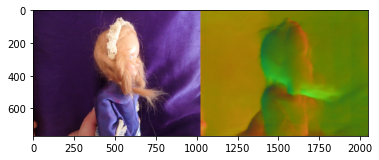

  4%|▍         | 44/1000 [02:30<54:15,  3.41s/it]

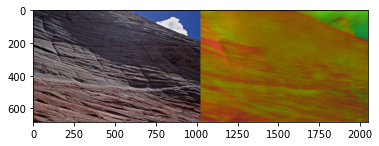

  4%|▍         | 45/1000 [02:33<53:41,  3.37s/it]

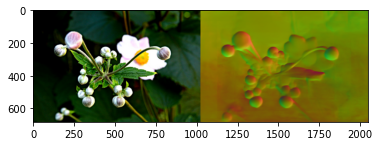

  5%|▍         | 46/1000 [02:37<53:41,  3.38s/it]

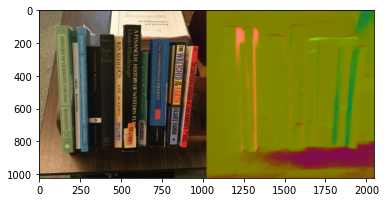

  5%|▍         | 47/1000 [02:40<54:06,  3.41s/it]

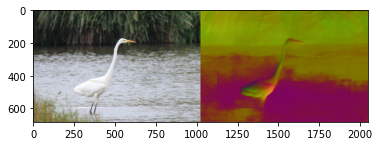

  5%|▍         | 48/1000 [02:43<54:05,  3.41s/it]

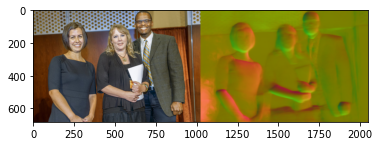

100%|██████████| 1000/1000 [51:04<00:00,  3.06s/it]


Mean angle error: 25.51158909256693 degs
% below 11.25 deg: 0.27802370670979876
% below 22.5 deg: 0.5766150379320703
% below 30 deg: 0.6989319438774855
Median angle error: 18.91875144426885 degs


In [18]:
transforms = ALL_TRANSFORMS[transform_name]

result = load_data_and_evaluate(
        pretrained_weights_path=weights_file,
        transforms=transforms,
        short_side_size=short_side_size,
        long_side_size=long_side_size,
        use_fixed_input_size=use_fixed_input_size, fixed_input_width=fixed_input_width, fixed_input_height=fixed_input_height,
        dataset_file='/scratch/ainaz/OASIS/OASIS_trainval/OASIS_val.csv',
        num_iters=n_ims_to_eval  
    )




+----------------------------------+
|  newdata_size_640_cos_l1_1e4
+----------------------------------+
Evaluation on OASISNormalDatasetVal
####################################
Evaluating...
	front_facing = False
	use_fixed_input_size = False
	size = (512, 512)


  0%|          | 0/1000 [00:00<?, ?it/s]

torch.Size([1, 3, 640, 640])


<ipython-input-15-a3b0a24606e5>:77: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  output = output_var.permute(0,2,3,1)[mask, :]
<ipython-input-15-a3b0a24606e5>:78: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
  target = targets.permute(0,2,3,1)[mask, :]


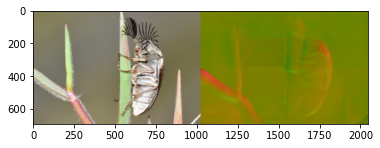

  0%|          | 1/1000 [00:01<21:39,  1.30s/it]

torch.Size([1, 3, 640, 640])


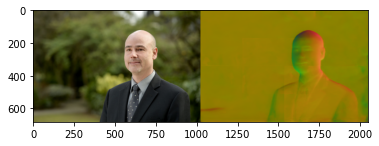

  0%|          | 2/1000 [00:02<20:58,  1.26s/it]

torch.Size([1, 3, 640, 640])


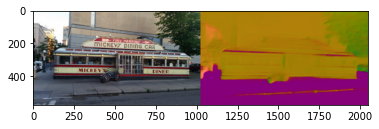

  0%|          | 3/1000 [00:03<20:03,  1.21s/it]

torch.Size([1, 3, 640, 640])


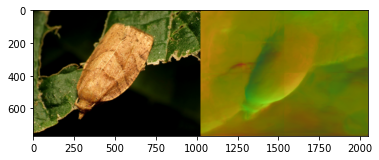

  0%|          | 4/1000 [00:04<19:31,  1.18s/it]

torch.Size([1, 3, 640, 640])


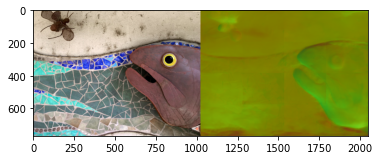

  0%|          | 5/1000 [00:05<19:39,  1.19s/it]

torch.Size([1, 3, 640, 640])


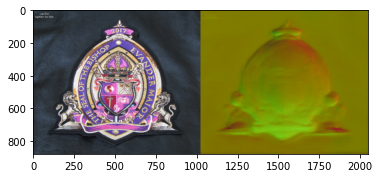

  1%|          | 6/1000 [00:07<19:37,  1.18s/it]

torch.Size([1, 3, 640, 640])


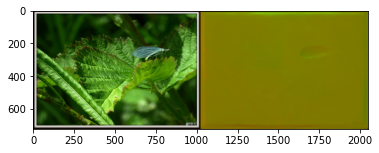

  1%|          | 7/1000 [00:08<18:45,  1.13s/it]

torch.Size([1, 3, 640, 640])


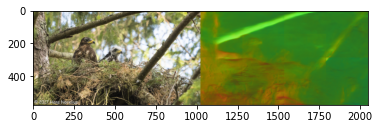

  1%|          | 8/1000 [00:09<18:56,  1.15s/it]

torch.Size([1, 3, 640, 640])


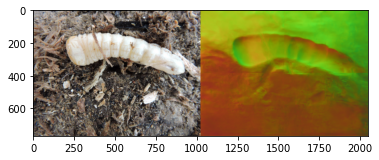

  1%|          | 9/1000 [00:10<18:58,  1.15s/it]

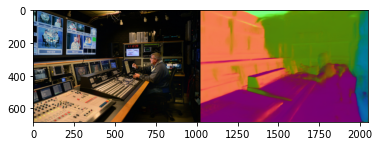

  1%|          | 10/1000 [00:11<18:16,  1.11s/it]

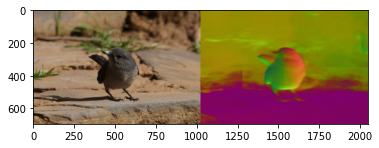

  1%|          | 11/1000 [00:12<19:11,  1.16s/it]

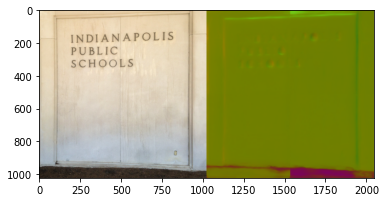

  1%|          | 12/1000 [00:13<19:47,  1.20s/it]

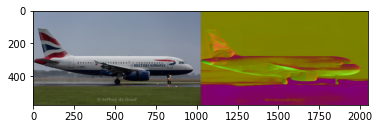

  1%|▏         | 13/1000 [00:15<19:00,  1.16s/it]

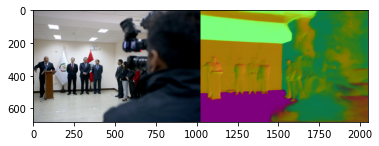

  1%|▏         | 14/1000 [00:16<19:07,  1.16s/it]

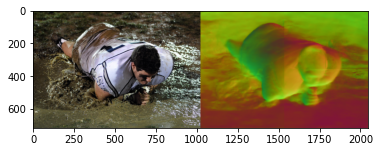

  2%|▏         | 15/1000 [00:17<19:06,  1.16s/it]

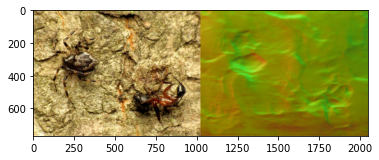

  2%|▏         | 16/1000 [00:18<19:07,  1.17s/it]

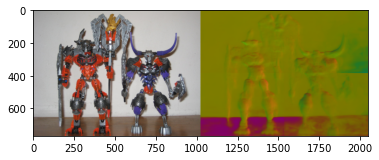

  2%|▏         | 17/1000 [00:19<19:22,  1.18s/it]

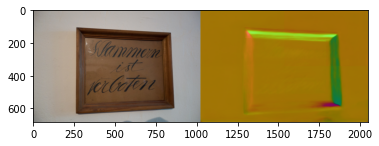

  2%|▏         | 18/1000 [00:20<19:05,  1.17s/it]

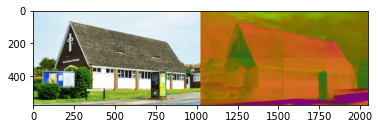

  2%|▏         | 19/1000 [00:22<18:44,  1.15s/it]

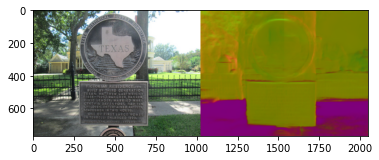

  2%|▏         | 20/1000 [00:23<18:35,  1.14s/it]

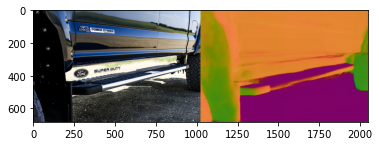

  2%|▏         | 21/1000 [00:24<18:24,  1.13s/it]

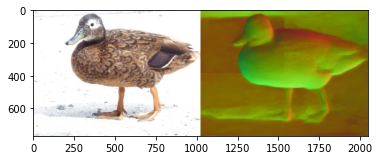

  2%|▏         | 22/1000 [00:25<18:27,  1.13s/it]

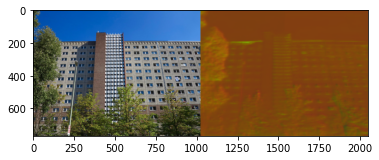

  2%|▏         | 23/1000 [00:26<18:28,  1.14s/it]

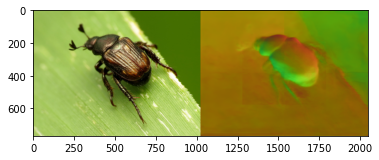

  2%|▏         | 24/1000 [00:27<18:12,  1.12s/it]

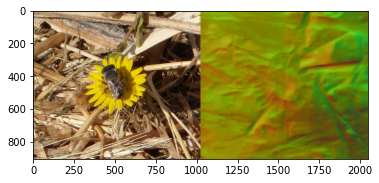

  2%|▎         | 25/1000 [00:28<18:45,  1.15s/it]

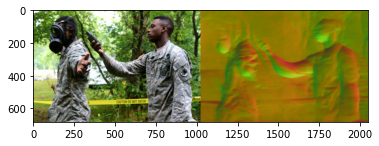

  3%|▎         | 26/1000 [00:29<18:19,  1.13s/it]

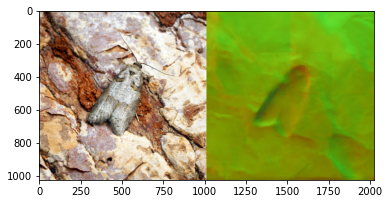

  3%|▎         | 27/1000 [00:31<18:28,  1.14s/it]

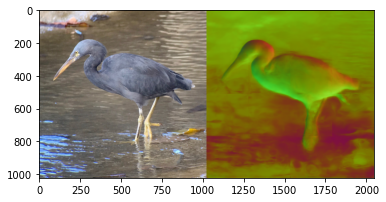

  3%|▎         | 28/1000 [00:32<18:40,  1.15s/it]

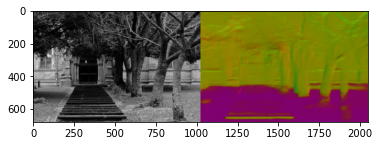

  3%|▎         | 29/1000 [00:33<18:09,  1.12s/it]

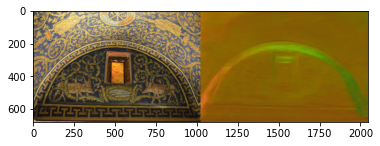

  3%|▎         | 30/1000 [00:34<18:10,  1.12s/it]

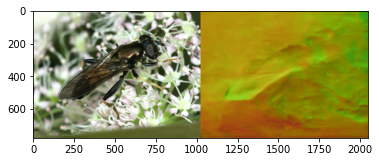

  3%|▎         | 31/1000 [00:35<18:45,  1.16s/it]

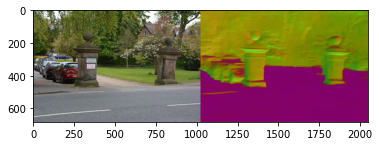

  3%|▎         | 32/1000 [00:36<18:30,  1.15s/it]

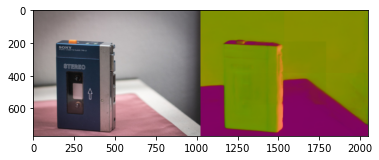

  3%|▎         | 33/1000 [00:37<18:19,  1.14s/it]

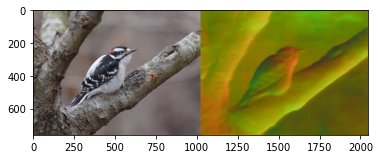

  3%|▎         | 34/1000 [00:39<18:13,  1.13s/it]

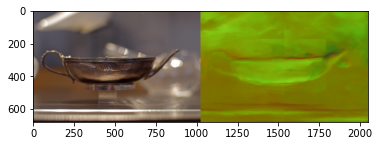

  4%|▎         | 35/1000 [00:40<18:03,  1.12s/it]

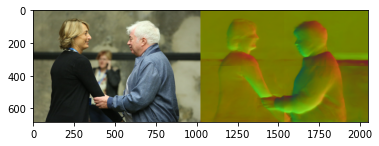

  4%|▎         | 36/1000 [00:41<17:50,  1.11s/it]

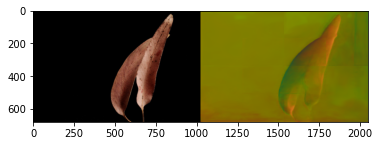

  4%|▎         | 37/1000 [00:42<17:46,  1.11s/it]

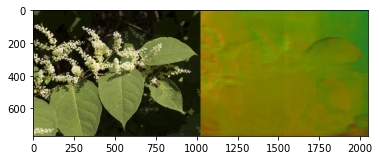

  4%|▍         | 38/1000 [00:43<17:48,  1.11s/it]

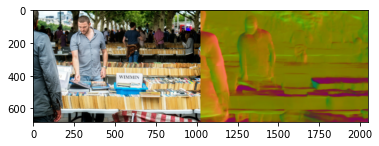

  4%|▍         | 39/1000 [00:44<17:37,  1.10s/it]

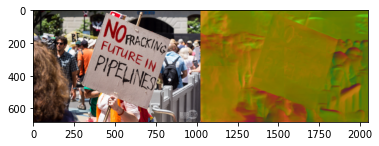

  4%|▍         | 40/1000 [00:45<17:59,  1.12s/it]

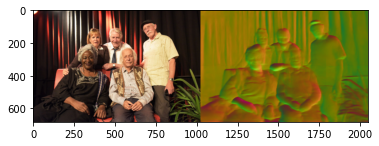

  4%|▍         | 41/1000 [00:46<18:17,  1.14s/it]

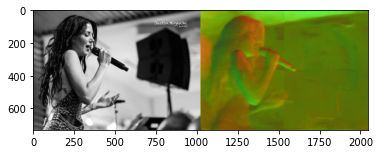

  4%|▍         | 42/1000 [00:47<18:10,  1.14s/it]

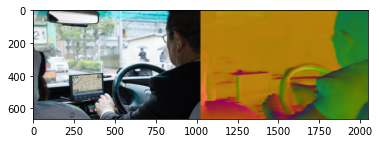

  4%|▍         | 43/1000 [00:49<17:41,  1.11s/it]

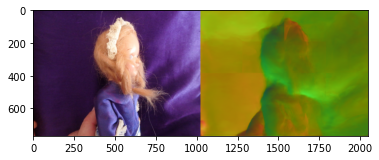

  4%|▍         | 44/1000 [00:50<17:48,  1.12s/it]

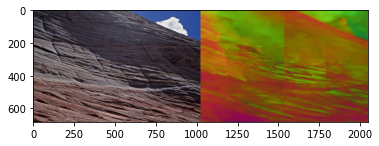

  4%|▍         | 45/1000 [00:51<17:58,  1.13s/it]

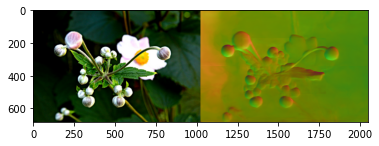

  5%|▍         | 46/1000 [00:52<18:11,  1.14s/it]

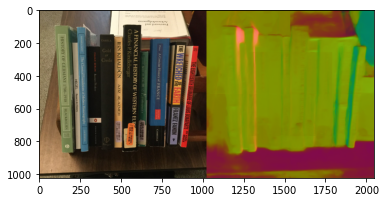

  5%|▍         | 47/1000 [00:53<18:37,  1.17s/it]

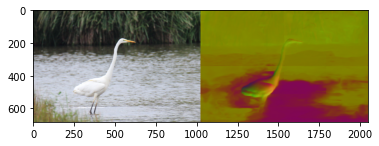

  5%|▍         | 48/1000 [00:54<18:43,  1.18s/it]

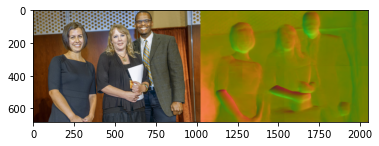

100%|██████████| 1000/1000 [15:11<00:00,  1.10it/s]


Mean angle error: 25.838524746956434 degs
% below 11.25 deg: 0.2630557555200217
% below 22.5 deg: 0.57523049047487
% below 30 deg: 0.7020383242118822
Median angle error: 19.02026000816629 degs


In [20]:
num_iters = 1000
b_vis_normal = True
front_facing = False
in_thresh = 0.0
WP = namedtuple('WeightPath', ['name', 'path'])



pretrained_weights_paths = [
#     WP('full_aug_1e3', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/2nrpj0i4/last.ckpt'),
#     WP('partial_aug_1e4v2', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/17d8udjm/last.ckpt'),
#     WP('partial_aug_1e3', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/1zeqrirc/last.ckpt'),
#     WP('full_aug_1e4', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/37kwjmko/last.ckpt'),

#     WP('full_aug_size_512_cos_l1_1e4', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/3i8uv0k8/epoch=13.ckpt'),
#     WP('full_aug_size_512_cos_l1_1e4_bk', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/3i8uv0k8/backup9.ckpt'),
#     WP('full_aug_size_512_cos_1e6_backup9', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/14lse6gi/epoch=0-v0.ckpt'),
#     WP('full_aug_size_512_cos_1e6_backup9', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/14lse6gi/backup9-2.ckpt'),
#     WP('full_aug_size_512_cos_l1_1e5_backup9', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/20mflkny/backup9-2.ckpt'),
#     WP('full_aug_size_512_l1_1e4', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/1mojwr16/epoch=4-v1.ckpt'),
#     WP('full_aug_size_512_cos_1e4', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/2trxgqjm/epoch=13-v0.ckpt'),
    WP('newdata_size_640_cos_l1_1e4', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/34t8zd61/epoch=1-v0.ckpt'),

    
#     WP('best_mae', '/scratch/sasha/omnidata/best_checkpoints/best_MAE_1k.pth'),
#     WP('best_mdae', '/scratch/sasha/omnidata/best_checkpoints/best_MDAE_1k.pth'),
    
]



crop_transforms = tta.Product(
    [
        tta.SurfaceNormalHorizontalFlip(dim_horizontal=0),
#         tta.HorizontalFlip(),
        tta.FiveCrops(0.5),
        tta.ResizeShortestEdge([512, 256]),
#         tta.ResizeShortestEdge([512]),
    ]
)

whole_transforms = tta.Product(
    [
        tta.SurfaceNormalHorizontalFlip(dim_horizontal=0),
        tta.ResizeShortestEdge([512, 256, 320, 384, 448]),
#         tta.ResizeShortestEdge([512], interpolation='nearest'),

    ]
)


transforms = whole_transforms
transforms = list(it.chain(crop_transforms, whole_transforms))



# transforms = ALL_TRANSFORMS[transform_name]


for wp in pretrained_weights_paths:
    with torch.no_grad():
        pretrained_weights_path = wp.path
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        model = UNet(in_channels=3, out_channels=3)

        checkpoint = torch.load(pretrained_weights_path, map_location='cuda:0')
        if 'state_dict' in checkpoint:
            state_dict = {}
            for k, v in checkpoint['state_dict'].items():
                state_dict[k.replace('model.', '')] = v
        else:
              state_dict = checkpoint
        model.load_state_dict(state_dict)
        model.to(device)
        model.eval().cuda()
        
        def model_fn(x):
            output_var = model(x) * 2 - 1
            output_var[:,2,:,:] *= -1 
            output_var = torch.nn.functional.normalize(output_var, p=2, dim=1)
            return output_var
        
        wrapper = tta.SurfaceNormalsTTAWrapper(model=model_fn, transforms=transforms, run_mode='parallel_apply', merger_fn=tta.MedianMerger)
        wrapper_fn = lambda x: torch.nn.functional.normalize(wrapper(x), p=2, dim=1)

        print("\n\n")
        print(f'+----------------------------------+')
        print(f'|  {wp.name}')
        print(f'+----------------------------------+')

        test_rel_error = valid(wrapper_fn, [1., 1., -1.], test_data_loader, dataset_name='OASISNormalDatasetVal', 
                                       max_iter = num_iters, in_thresh=0.0, b_vis_normal=True, 
                                       verbal=True, front_facing=False, 
                                       use_fixed_input_size=use_fixed_input_size, fixed_input_width=fixed_input_width, fixed_input_height=fixed_input_width)

In [ ]:
# blind guess
Mean angle error: 39.44231176595006 degs
% below 11.25 deg: 0.09704038115136228
% below 22.5 deg: 0.29387997977149927
% below 30 deg: 0.42241988228668487
Median angle error: 34.902119809698 degs

#### Current best model
- (1k images, all transforms, medianmerger)
- Resize to 512 before feeding into model

`WP('full_aug_size_512_cos_l1_1e4_bk', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/3i8uv0k8/backup2.ckpt')`

    +----------------------------------+
    |  full_aug_size_512_cos_l1_1e4_bk
    +----------------------------------+
    100%|██████████| 1000/1000 [09:00<00:00,  1.85it/s]
    Mean angle error: 25.316136451166084 degs
    % below 11.25 deg: 0.2898696632665863
    % below 22.5 deg: 0.5813508698717492
    % below 30 deg: 0.7016832530930006
    Median angle error: 18.885355234322073 degs
    
    

`WP('full_aug_size_512_cos_l1_1e4_bk', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/3i8uv0k8/backup5.ckpt')`

    +----------------------------------+
    |  full_aug_size_512_cos_l1_1e4 
    +----------------------------------+
    100%|██████████| 1000/1000 [11:33<00:00,  1.44it/s]
    Mean angle error: 25.238150962347802 degs
    % below 11.25 deg: 0.2899215457908137
    % below 22.5 deg: 0.5938330035678583
    % below 30 deg: 0.7096475931356914
    Median angle error: 18.237470810411345 degs
    
    
    

`WP('full_aug_size_512_cos_l1_1e4_bk', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/3i8uv0k8/backup6.ckpt')`

    +----------------------------------+
    |  full_aug_size_512_cos_l1_1e4_bk
    +----------------------------------+
    100%|██████████| 1000/1000 [11:32<00:00,  1.44it/s]

    Mean angle error: 25.26480145004401 degs
    % below 11.25 deg: 0.29271456230084536
    % below 22.5 deg: 0.5919395207592015
    % below 30 deg: 0.7115616158343351
    Median angle error: 18.248325688549787 degs
    
    
    
`WP('full_aug_size_512_cos_l1_1e4_bk', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/3i8uv0k8/backup9.ckpt')`

    +----------------------------------+
    |  full_aug_size_512_cos_l1_1e4_bk  (1k images)  (tta.FiveCrops(0.9))
    +----------------------------------+
    100%|██████████| 1000/1000 [13:34<00:00,  1.23it/s]

    Mean angle error: 24.743782259946336 degs
    % below 11.25 deg: 0.30209001210741404
    % below 22.5 deg: 0.6148413846146374
    % below 30 deg: 0.7213106646785566
    Median angle error: 17.44701472531306 degs
    
    +----------------------------------+
    |  full_aug_size_512_cos_l1_1e4_bk  (1k images)  (tta.FiveCrops(0.8))
    +----------------------------------+
    100%|██████████| 1000/1000 [13:34<00:00,  1.23it/s]
    
    Mean angle error: 24.64950584634545 degs
    % below 11.25 deg: 0.30581079615654855
    % below 22.5 deg: 0.6121422161102369
    % below 30 deg: 0.7225391543638778
    Median angle error: 17.256182654997488 degs
    
    
    +----------------------------------+
    |  full_aug_size_512_cos_l1_1e4_bk  (1k images)  (tta.FiveCrops(0.7))
    +----------------------------------+
    100%|██████████| 1000/1000 [13:34<00:00,  1.23it/s]

    Mean angle error: 24.467584296249598 degs
    % below 11.25 deg: 0.3124939770460715
    % below 22.5 deg: 0.6153203385355163
    % below 30 deg: 0.7246273235551958
    Median angle error: 17.11329339001353 degs
    
    +----------------------------------+
    |  full_aug_size_512_cos_l1_1e4_bk  (1k images)  (tta.FiveCrops(0.6))
    +----------------------------------+
    100%|██████████| 1000/1000 [13:34<00:00,  1.23it/s]

    Mean angle error: 24.472359526472975 degs
    % below 11.25 deg: 0.30506028446363176
    % below 22.5 deg: 0.615442193418765
    % below 30 deg: 0.7252828070499076
    Median angle error: 17.15645335537884 degs
    
    +----------------------------------+
    |  full_aug_size_512_cos_l1_1e4_bk  (1k images)  (tta.FiveCrops(0.5))
    +----------------------------------+
    100%|██████████| 1000/1000 [13:34<00:00,  1.23it/s]

    Mean angle error: 24.427346639304954 degs
    % below 11.25 deg: 0.3051479591542613
    % below 22.5 deg: 0.6183725888835937
    % below 30 deg: 0.7274257644118649
    Median angle error: 17.259222089178145 degs
    
    
    +----------------------------------+
    |  full_aug_size_512_cos_l1_1e4_bk  (10k images) (tta.FiveCrops(0.9))
    +----------------------------------+
    100%|██████████| 10000/10000 [1:20:01<00:00,  2.08it/s]

    Mean angle error: 25.150983772803418 degs
    % below 11.25 deg: 0.31466922792651436
    % below 22.5 deg: 0.5932042355181402
    % below 30 deg: 0.7084016859519051
    Median angle error: 17.915437636329 degs



`WP('full_aug_size_512_cos_l1_1e4_bk', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/3i8uv0k8/backup10.ckpt')`

    +----------------------------------+
    |  full_aug_size_512_cos_l1_1e4
    +----------------------------------+
    100%|██████████| 1000/1000 [08:01<00:00,  2.08it/s]

    Mean angle error: 24.904615317215047 degs
    % below 11.25 deg: 0.2975541235179561
    % below 22.5 deg: 0.6022512945010334
    % below 30 deg: 0.7209121908128091
    Median angle error: 17.825772620452362 degs
    
    
`WP('full_aug_size_512_cos_l1_1e4_bk', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/3i8uv0k8/backup11.ckpt')`

    +----------------------------------+
    |  full_aug_size_512_cos_l1_1e4
    +----------------------------------+
    100%|██████████| 1000/1000 [08:01<00:00,  2.08it/s]

    Mean angle error: 24.78877780148264 degs
    % below 11.25 deg: 0.30083909876319
    % below 22.5 deg: 0.601188962312502
    % below 30 deg: 0.7193859975507373
    Median angle error: 17.91620261751604 degs
    
    
`WP('full_aug_size_512_cos_1e6_backup9', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/14lse6gi/backup9-1.ckpt')`

    +----------------------------------+
    |  full_aug_size_512_cos_1e6_backup9  (1k images)  (tta.FiveCrops(0.5))
    +----------------------------------+
    100%|██████████| 1000/1000 [08:01<00:00,  2.08it/s]

    Mean angle error: 24.602346157605137 degs
    % below 11.25 deg: 0.29129061456848776
    % below 22.5 deg: 0.6046428185758498
    % below 30 deg: 0.7279105058155578
    Median angle error: 17.794676476708588 degs
    
    
`WP('full_aug_size_512_cos_1e6_backup9', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/14lse6gi/backup9-2.ckpt')`

    +----------------------------------+
    |  full_aug_size_512_cos_1e6_backup9  (1k images)  (tta.FiveCrops(0.5))
    +----------------------------------+
    100%|██████████| 1000/1000 [08:01<00:00,  2.08it/s]

    Mean angle error: 24.52499051542612 degs
    % below 11.25 deg: 0.29549180508320744
    % below 22.5 deg: 0.6073094410004256
    % below 30 deg: 0.729091515445793
    Median angle error: 17.67397166614883 degs
    
    
    +----------------------------------+
    |  full_aug_size_512_cos_1e6_backup9  (10k images)  (tta.FiveCrops(0.5))
    +----------------------------------+
    100%|██████████| 10000/10000 [1:20:25<00:00,  2.07it/s]

    Mean angle error: 25.057351992351162 degs
    % below 11.25 deg: 0.3023123057900251
    % below 22.5 deg: 0.5888424492421614
    % below 30 deg: 0.7081003051374243
    Median angle error: 18.268064935251125 degs


`WP('full_aug_size_512_cos_l1_1e4_bk', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/3i8uv0k8/backup12.ckpt')`

    +----------------------------------+
    |  full_aug_size_512_cos_l1_1e4       (1k images)  (tta.FiveCrops(0.5))
    +----------------------------------+
    100%|██████████| 1000/1000 [08:01<00:00,  2.08it/s]

    Mean angle error: 24.572130963177397 degs
    % below 11.25 deg: 0.2929986028789527
    % below 22.5 deg: 0.6115561824092932
    % below 30 deg: 0.7298942733561131
    Median angle error: 17.736138340426994 degs
    
    
`WP('full_aug_size_512_cos_l1_1e5_backup9', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/20mflkny/backup9-1.ckpt')`

    +----------------------------------+
    |  full_aug_size_512_cos_l1_1e5_backup9       (1k images)  (tta.FiveCrops(0.5))
    +----------------------------------+
    100%|██████████| 1000/1000 [08:01<00:00,  2.08it/s]

    Mean angle error: 24.48317090819299 degs
    % below 11.25 deg: 0.29384999834092157
    % below 22.5 deg: 0.6090088275227081
    % below 30 deg: 0.7327148882155639
    Median angle error: 17.462884669849586 degs
    
`WP('full_aug_size_512_cos_l1_1e5_backup9', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/20mflkny/backup9-2.ckpt')`

    +----------------------------------+
    |  full_aug_size_512_cos_l1_1e5_backup9       (1k images)  (tta.FiveCrops(0.5))
    +----------------------------------+
    100%|██████████| 1000/1000 [08:01<00:00,  2.08it/s]

    Mean angle error: 24.366036177974816 degs
    % below 11.25 deg: 0.30380249422806394
    % below 22.5 deg: 0.6124827697558223
    % below 30 deg: 0.7306249941274071
    Median angle error: 17.229787388949976 degs

# Relative Normal

In [10]:
# normalize normals
def normalize(normal_map):
    l2_norms = linalg.norm(normal_map, axis = 2)
    l2_norms = np.stack([l2_norms, l2_norms, l2_norms], axis = -1)
    return np.divide(normal_map, l2_norms)


def ang_diff(vec1, vec2):
    '''
        calculate the angle difference between two vectors
        return between 0 and pi, in radians
    '''
    dot_prod = np.dot(vec1, vec2)
    dot_prod = min(dot_prod, 1.0)
    dot_prod = max(dot_prod, -1.0)
    ang = math.acos(dot_prod)
    return ang

def precision_recall_perpen(ang_diffs, neither_ang_diffs):
    '''
    Get the recall curve for the perpendicular case.
    Threshold on (ang_diffs - math.pi / 2.0), i.e., distance to 90 degree
    Input
        ang_diffs: a list of angular difference measured in radian, supposed to be perpendicular
        neither_ang_diffs: a list of angular difference measured in radian, supposed to be not perpendicular
    Output:
        The AUC score for the recall curve.
        And a plot of the curve stored in "perpen.pdf"
    '''
    plt.clf()
    n_pos_sample = len(ang_diffs)
    n_neg_sample = len(neither_ang_diffs)
    # This will be either TP or FN
    np_ang_diffs = np.array(ang_diffs).copy()
    np_ang_diffs = [val for val in np.abs(np_ang_diffs - (math.pi / 2.0))] # dist to 90 degree

    # This will be either FP or TN
    np_neither_ang_diffs = np.array(neither_ang_diffs).copy()
    np_neither_ang_diffs = [val for val in np.abs(neither_ang_diffs - (math.pi / 2.0))] # dist to 90 degree

    # recall = [0, 0] # Needs at least two points to calculate area under the curve
    # precision = [1, 1]

    all_ang_diffs = np_ang_diffs + np_neither_ang_diffs
    all_ang_diffs = convert_ang_to_prob(all_ang_diffs)
    true_labels = [1 for i in range(n_pos_sample)] + [0 for i in range(n_neg_sample)]
    precision, recall, _= precision_recall_curve(true_labels, all_ang_diffs)
    AP = average_precision_score(true_labels, all_ang_diffs)

    plt.plot(recall, precision, 'b*-')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([0.0, 1.1])
    plt.ylim([0.0, 1.1])
    plt.title('Perpendicular Precision-Recall Curve: AP = %.2f' % (AP) )
    plt.savefig("Perpendicular.pdf", bbox_inches='tight')

    return AP

def precision_recall_parall(ang_diffs, neither_ang_diffs):
    '''
    Get the recall curve for the parallel case.
    Threshold on the ang_diffs.
    Input
        ang_diffs: a list of angular difference measured in radian, supposed to be parallel
        neither_ang_diffs: a list of angular difference measured in radian, suppose to be not parallel
    Output:
        The AUC score for the recall curve, i.e. AP
        And a plot of the curve stored in "parall.pdf"
    '''
    plt.clf()
    n_pos_sample = len(ang_diffs)
    n_neg_sample = len(neither_ang_diffs)

    # This will be either TP or FN
    np_ang_diffs_ali = np.array(ang_diffs).copy() # when two vectors point to the same direction
    np_ang_diffs_rev = np.pi - np.array(ang_diffs) # when two vectors point to the opposite direction
    np_ang_diffs = [min(np_ang_diffs_ali[i], np_ang_diffs_rev[i]) for i in range(len(np_ang_diffs_rev))]

    # This will be either FP or TN
    np_neither_ang_diffs_ali = np.array(neither_ang_diffs).copy() # when two vectors point to the same direction
    np_neither_ang_diffs_rev = np.pi - np.array(neither_ang_diffs) # when two vectors point to the opposite direction
    np_neither_ang_diffs = [min(np_neither_ang_diffs_ali[i], np_neither_ang_diffs_rev[i]) for i in range(len(np_neither_ang_diffs_rev))]

    # recall = [0, 0]  # Needs at least two points to calculate area under the curve
    # precision = [1, 1]

    all_ang_diffs = np_ang_diffs + np_neither_ang_diffs
    all_ang_diffs = convert_ang_to_prob(all_ang_diffs)
    true_labels = [1 for i in range(n_pos_sample)] + [0 for i in range(n_neg_sample)]
    precision, recall, _= precision_recall_curve(true_labels, all_ang_diffs)
    AP = average_precision_score(true_labels, all_ang_diffs)

    plt.plot(recall, precision, 'b*-')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([0.0, 1.1])
    plt.ylim([0.0, 1.1])
    plt.title('Parallel Precision-Recall Curve: AP= %.2f' % (AP) )
    plt.savefig("Parallel.pdf", bbox_inches='tight')

    return AP

# Angles are in range from 0 to pi radians. Note that the perpendicular function already subtracts by pi/2 radians so we don't have to
# To compute precision recall, you need probabilities.
# Error of pi radians -> prob of 0.
# Error of 0 radians -> prob of 1.
def convert_ang_to_prob(angles):
  for i in range(len(angles)):
    angles[i] = 1.0 - (angles[i] / math.pi)
  return angles


def get_ang_diffs(pred_normal, xyxyr_tups):
    assert(len(pred_normal.shape) == 3)
    assert(pred_normal.shape[2] == 3)

    NEITHER_REL = "neither" # REVIEW

    unit_pred_normal = normalize(pred_normal)
    ang_diffs = []
    for xyxyr in xyxyr_tups:
        x_A = xyxyr[0]
        y_A = xyxyr[1]
        x_B = xyxyr[2]
        y_B = xyxyr[3]
        rel = xyxyr[4]
        assert(rel == "parallel" or rel == "perpendicular" or rel == NEITHER_REL)

        norm_A = unit_pred_normal[y_A, x_A, :]
        norm_B = unit_pred_normal[y_B, x_B, :]

        ang_diffs.append(ang_diff(norm_A, norm_B))

    perpendi_idx = [i for i in range(len(xyxyr_tups)) if xyxyr_tups[i][4] == 'perpendicular']
    parallel_idx = [i for i in range(len(xyxyr_tups)) if xyxyr_tups[i][4] == 'parallel']
    neither_idx = [i for i in range(len(xyxyr_tups)) if xyxyr_tups[i][4] == NEITHER_REL]
    
    
    perpendi_ang_diffs = [ang_diffs[i] for i in perpendi_idx]
    parallel_ang_diffs = [ang_diffs[i] for i in parallel_idx]
    neither_ang_diffs  = [ang_diffs[i] for i in neither_idx]

    return perpendi_ang_diffs, parallel_ang_diffs, neither_ang_diffs


def eval_rel_normal_by_ang(perpendi_ang_diffs, parallel_ang_diffs, neither_ang_diffs):
    '''
    Evaluate the relative normals of a list of predicted normal maps.
    Input:
        perpendi_ang_diffs 
        parallel_ang_diffs
        neither_ang_diffs
    Output:
        Two curves: x axis is the threshold, y axis is the recall.
        The area under the curve for the perpendicular and parallel curves.
    '''

    perpendi_ang_diffs, parallel_ang_diffs, neither_ang_diffs = np.array(perpendi_ang_diffs), np.array(parallel_ang_diffs), np.array(neither_ang_diffs)
    perpendi_ang_diffs = perpendi_ang_diffs[~np.isnan(perpendi_ang_diffs)]
    parallel_ang_diffs = parallel_ang_diffs[~np.isnan(parallel_ang_diffs)]
    neither_ang_diffs = neither_ang_diffs[~np.isnan(neither_ang_diffs)]

    perpendi_AP = precision_recall_perpen(perpendi_ang_diffs, neither_ang_diffs)
    parallel_AP = precision_recall_parall(parallel_ang_diffs, neither_ang_diffs)

    return perpendi_AP, parallel_AP


def eval_rel_normal(list_pred_normal, list_xyxyr_tups):
    '''
    Evaluate the relative normals of a list of predicted normal maps.
    Input:
        list_pred_normal: a list of numpy arrays HxWx3. The  predicted normal maps .
                          Does not assumed to be unit-normalized
                    [
                        normal map1,
                        normal map2,
                        ...
                    ]
        list_xyxyr_tups : a list of list of tuples (x_A, y_A, x_B, y_B, relation)
                    relation can be either "parallel", "perpendicular" or "neither"
                    [
                        [(x_A, y_A, x_B, y_B, relation), (x_A, y_A, x_B, y_B, relation), ...],  # for 1st normal map
                        [(x_A, y_A, x_B, y_B, relation), (x_A, y_A, x_B, y_B, relation), ...],  # for 2nd normal map
                        ...
                    ]
        snap_thresh_parall: beyond this thresh is no longer considered as parallel
        snap_thresh_perpen: beyond this thresh (i.e., distance to 90 degree) is no longer considered as perpendicular
    Output:
        Two curves: x axis is the threshold, y axis is the recall.
        The area under the curve for the perpendicular and parallel curves.
    '''

    assert(len(list_pred_normal) == len(list_xyxyr_tups))

    perpendi_ang_diffs = []
    parallel_ang_diffs = []
    neither_ang_diffs = []
    for pred_normal, xyxyr_tups in zip(list_pred_normal, list_xyxyr_tups):
        _perpendi, _parallel, _neither = get_ang_diffs(pred_normal, xyxyr_tups)
        perpendi_ang_diffs += _perpendi
        parallel_ang_diffs += _parallel
        neither_ang_diffs  += _neither


    perpendi_AP, parallel_AP = eval_rel_normal_by_ang(perpendi_ang_diffs, parallel_ang_diffs, neither_ang_diffs)

    return perpendi_AP, parallel_AP

In [11]:
def valid_relative_normal(model):
    perpendi_ang_diffs = []
    parallel_ang_diffs = []
    neither_ang_diffs = []
    test_file = '/scratch/ainaz/OASIS/OASIS_trainval/rel_normal_pair_val.csv'

    image_pairs_map = defaultdict(list)
    for line in open(test_file, 'r'):
        im_name, y_A, x_A, y_B, x_B, rel = line.strip().split(',')
        x_A = int(x_A)
        y_A = int(y_A)
        x_B = int(x_B)
        y_B = int(y_B)

        image_pairs_map[im_name].append((x_A, y_A, x_B, y_B, rel))

    for idx, im_name in enumerate(image_pairs_map):
    #     color = cv2.imread(im_name).astype(np.float32)
        img_path = os.path.join('/scratch/ainaz/OASIS/OASIS_trainval/image/', im_name.split('/')[-1])
        color = np.array(Image.open(img_path)).astype(np.float32) # my code
        if len(color.shape) < 3:
            print(":/")
            continue
        anno_id = im_name.split('/')[-1].replace('.png', '')
        print(im_name)
        
        orig_height, orig_width = color.shape[:2]
        size = 512
        color = cv2.resize(color, (size, size))
        color = np.transpose(color, (2, 0, 1)) / 255.0
        color = torch.tensor(color).to(device).unsqueeze(0)
        output = model(color)
        output = torch.nn.functional.interpolate(output, (orig_height, orig_width), mode='nearest')    
        output = torch.clamp(output, -1, 1) # my code
        output = output.cpu().detach().numpy()

        ####
        if idx == 500:
            print(output.shape)
            im = output.squeeze().transpose(1, 2, 0) * 255.0
            plt.imshow(np.uint8(im))
            plt.show()
            #break
        ####


        # Model does inference on 4D tensor, but eval function takes 3D
        # Has to be HxWx3
        output = np.transpose(output[0,:,:,:], (1,2,0))


        _perpendi, _parallel, _neither = get_ang_diffs(pred_normal = output, xyxyr_tups = image_pairs_map[im_name])
        perpendi_ang_diffs += _perpendi
        parallel_ang_diffs += _parallel
        neither_ang_diffs  += _neither

    print('Evaluating:', idx)
    perpendi_AP, parallel_AP = eval_rel_normal_by_ang(perpendi_ang_diffs, parallel_ang_diffs, neither_ang_diffs)  
    print('Perpendicular AP: {}, Parallel AP: {}'.format(perpendi_AP, parallel_AP))





+----------------------------------+
|  full_aug_size_512_cos_l1_1e4_bk
+----------------------------------+
/home/wfchen/OASIS_trainval/image/260767_ALI.png
/home/wfchen/OASIS_trainval/image/268026_ALI.png
/home/wfchen/OASIS_trainval/image/261648_ALI.png
/home/wfchen/OASIS_trainval/image/260573_ALI.png
/home/wfchen/OASIS_trainval/image/269107_ALI.png
/home/wfchen/OASIS_trainval/image/257046_ALI.png
/home/wfchen/OASIS_trainval/image/238240_ALI.png
/home/wfchen/OASIS_trainval/image/255370_ALI.png
/home/wfchen/OASIS_trainval/image/248537_ALI.png
/home/wfchen/OASIS_trainval/image/246562_ALI.png
/home/wfchen/OASIS_trainval/image/259778_ALI.png
/home/wfchen/OASIS_trainval/image/260523_ALI.png
/home/wfchen/OASIS_trainval/image/251628_ALI.png
/home/wfchen/OASIS_trainval/image/250959_ALI.png
/home/wfchen/OASIS_trainval/image/240073_ALI.png
/home/wfchen/OASIS_trainval/image/251758_ALI.png
/home/wfchen/OASIS_trainval/image/252338_ALI.png
/home/wfchen/OASIS_trainval/image/263525_ALI.png
/home/

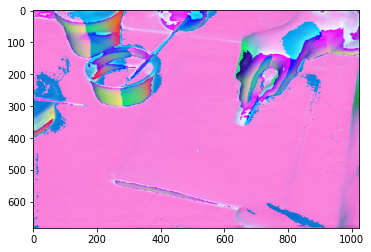

/home/wfchen/OASIS_trainval/image/247287_ALI.png
/home/wfchen/OASIS_trainval/image/257186_ALI.png
/home/wfchen/OASIS_trainval/image/249778_ALI.png
/home/wfchen/OASIS_trainval/image/250198_ALI.png
/home/wfchen/OASIS_trainval/image/239777_ALI.png
/home/wfchen/OASIS_trainval/image/249100_ALI.png
/home/wfchen/OASIS_trainval/image/238403_ALI.png
/home/wfchen/OASIS_trainval/image/246903_ALI.png
/home/wfchen/OASIS_trainval/image/258151_ALI.png
/home/wfchen/OASIS_trainval/image/237066_ALI.png
/home/wfchen/OASIS_trainval/image/268145_ALI.png
/home/wfchen/OASIS_trainval/image/255230_ALI.png
/home/wfchen/OASIS_trainval/image/262459_ALI.png
/home/wfchen/OASIS_trainval/image/244493_ALI.png
/home/wfchen/OASIS_trainval/image/243445_ALI.png
/home/wfchen/OASIS_trainval/image/256214_ALI.png
/home/wfchen/OASIS_trainval/image/246945_ALI.png
/home/wfchen/OASIS_trainval/image/256379_ALI.png
/home/wfchen/OASIS_trainval/image/242688_ALI.png
/home/wfchen/OASIS_trainval/image/253990_ALI.png
/home/wfchen/OASIS_t

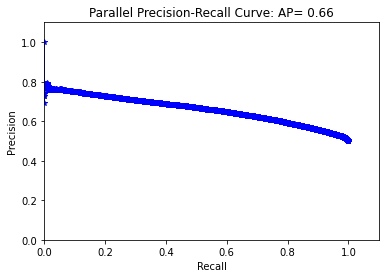

In [12]:

WP = namedtuple('WeightPath', ['name', 'path'])

pretrained_weights_paths = [
#     WP('full_aug_1e3', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/2nrpj0i4/last.ckpt'),
#     WP('partial_aug_1e4v2', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/17d8udjm/last.ckpt'),
#     WP('partial_aug_1e3', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/1zeqrirc/last.ckpt'),
#     WP('full_aug_1e4', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/37kwjmko/last.ckpt'),


#     WP('full_aug_size_512_cos_l1_1e4', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/3i8uv0k8/epoch=2-v1.ckpt'),
    WP('full_aug_size_512_cos_l1_1e4_bk', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/3i8uv0k8/backup9.ckpt'),
#     WP('full_aug_size_512_l1_1e3_oasis_val', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/owmw838g/epoch=1-v0.ckpt'),
#     WP('full_aug_size_512_cos_l1_1e4_oasis_val', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/21ztdscu/epoch=0-v0.ckpt'),
#     WP('full_aug_size_512_cos_l1_1e4_oasis_val_augment', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/1d7d3qt1/epoch=0-v1.ckpt'),

#     WP('full_aug_size_512_cos_l1_1e3', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/2t4krb4o/epoch=1-v0.ckpt'),
#     WP('full_aug_size_512_cos_1e4', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/2trxgqjm/epoch=2-v0.ckpt'),

#     WP('partial_aug_1e4', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/4l635hxn/epoch=5.ckpt'),
#     WP('full_aug_size_512_cos_l1_1e5', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/2tdo6nx9/epoch=0-v0.ckpt'),

]



crop_transforms = tta.Product(
    [
        tta.SurfaceNormalHorizontalFlip(dim_horizontal=0),
#         tta.HorizontalFlip(),
        tta.FiveCrops(0.9),
        tta.ResizeShortestEdge([512, 256]),
#         tta.ResizeShortestEdge([512]),
    ]
)

whole_transforms = tta.Product(
    [
        tta.SurfaceNormalHorizontalFlip(dim_horizontal=0),
        tta.ResizeShortestEdge([512, 256, 320, 384, 448]),
#         tta.ResizeShortestEdge([512], interpolation='nearest'),

    ]
)


transforms = whole_transforms
transforms = list(it.chain(crop_transforms, whole_transforms))


for wp in pretrained_weights_paths:
    with torch.no_grad():
        pretrained_weights_path = wp.path
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        model = UNet(in_channels=3, out_channels=3)

        checkpoint = torch.load(pretrained_weights_path, map_location='cuda:0')
        if 'state_dict' in checkpoint:
            state_dict = {}
            for k, v in checkpoint['state_dict'].items():
                state_dict[k.replace('model.', '')] = v
        else:
              state_dict = checkpoint
        model.load_state_dict(state_dict)
        model.to(device)
        model.eval().cuda()
        
        def model_fn(x):
            output_var = model(x) * 2 - 1
            output_var[:,2,:,:] *= -1 
            output_var = torch.nn.functional.normalize(output_var, p=2, dim=1)
            return output_var
        
        wrapper = tta.SurfaceNormalsTTAWrapper(model=model_fn, transforms=transforms, run_mode='parallel_apply', merger_fn=tta.MedianMerger)
        wrapper_fn = lambda x: torch.nn.functional.normalize(wrapper(x), p=2, dim=1)

        print("\n\n")
        print(f'+----------------------------------+')
        print(f'|  {wp.name}')
        print(f'+----------------------------------+')

        valid_relative_normal(wrapper_fn)




+----------------------------------+
|  Baseline
+----------------------------------+
/home/wfchen/OASIS_trainval/image/260767_ALI.png
/home/wfchen/OASIS_trainval/image/268026_ALI.png
/home/wfchen/OASIS_trainval/image/261648_ALI.png
/home/wfchen/OASIS_trainval/image/260573_ALI.png
/home/wfchen/OASIS_trainval/image/269107_ALI.png
/home/wfchen/OASIS_trainval/image/257046_ALI.png
/home/wfchen/OASIS_trainval/image/238240_ALI.png
/home/wfchen/OASIS_trainval/image/255370_ALI.png
/home/wfchen/OASIS_trainval/image/248537_ALI.png
/home/wfchen/OASIS_trainval/image/246562_ALI.png
/home/wfchen/OASIS_trainval/image/259778_ALI.png
/home/wfchen/OASIS_trainval/image/260523_ALI.png
/home/wfchen/OASIS_trainval/image/251628_ALI.png
/home/wfchen/OASIS_trainval/image/250959_ALI.png
/home/wfchen/OASIS_trainval/image/240073_ALI.png
/home/wfchen/OASIS_trainval/image/251758_ALI.png
/home/wfchen/OASIS_trainval/image/252338_ALI.png
/home/wfchen/OASIS_trainval/image/263525_ALI.png
/home/wfchen/OASIS_trainval/i

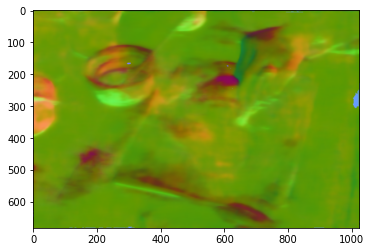

/home/wfchen/OASIS_trainval/image/247287_ALI.png
/home/wfchen/OASIS_trainval/image/257186_ALI.png
/home/wfchen/OASIS_trainval/image/249778_ALI.png
/home/wfchen/OASIS_trainval/image/250198_ALI.png
/home/wfchen/OASIS_trainval/image/239777_ALI.png
/home/wfchen/OASIS_trainval/image/249100_ALI.png
/home/wfchen/OASIS_trainval/image/238403_ALI.png
/home/wfchen/OASIS_trainval/image/246903_ALI.png
/home/wfchen/OASIS_trainval/image/258151_ALI.png
/home/wfchen/OASIS_trainval/image/237066_ALI.png
/home/wfchen/OASIS_trainval/image/268145_ALI.png
/home/wfchen/OASIS_trainval/image/255230_ALI.png
/home/wfchen/OASIS_trainval/image/262459_ALI.png
/home/wfchen/OASIS_trainval/image/244493_ALI.png
/home/wfchen/OASIS_trainval/image/243445_ALI.png
/home/wfchen/OASIS_trainval/image/256214_ALI.png
/home/wfchen/OASIS_trainval/image/246945_ALI.png
/home/wfchen/OASIS_trainval/image/256379_ALI.png
/home/wfchen/OASIS_trainval/image/242688_ALI.png
/home/wfchen/OASIS_trainval/image/253990_ALI.png
/home/wfchen/OASIS_t

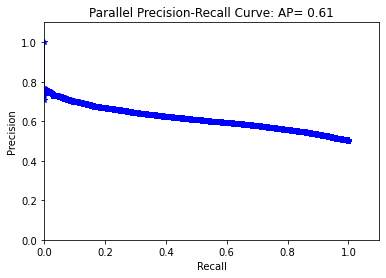

In [33]:

WP = namedtuple('WeightPath', ['name', 'path'])

pretrained_weights_paths = [
#     WP('full_aug_1e3', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/2nrpj0i4/last.ckpt'),
#     WP('partial_aug_1e4v2', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/17d8udjm/last.ckpt'),
#     WP('partial_aug_1e3', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/1zeqrirc/last.ckpt'),
#     WP('full_aug_1e4', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/37kwjmko/last.ckpt'),
    WP('Baseline', '/scratch/ainaz/XTConsistency/models/rgb2normal_baseline.pth'),


#     WP('full_aug_size_512_cos_l1_1e4', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/3i8uv0k8/epoch=2-v1.ckpt'),
#     WP('full_aug_size_512_cos_l1_1e4_bk', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/3i8uv0k8/backup6.ckpt'),
#     WP('full_aug_size_512_l1_1e3_oasis_val', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/owmw838g/epoch=1-v0.ckpt'),
#     WP('full_aug_size_512_cos_l1_1e4_oasis_val', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/21ztdscu/epoch=0-v0.ckpt'),
#     WP('full_aug_size_512_cos_l1_1e4_oasis_val_augment', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/1d7d3qt1/epoch=0-v1.ckpt'),

#     WP('full_aug_size_512_cos_l1_1e3', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/2t4krb4o/epoch=1-v0.ckpt'),
#     WP('full_aug_size_512_cos_1e4', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/2trxgqjm/epoch=2-v0.ckpt'),

#     WP('partial_aug_1e4', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/4l635hxn/epoch=5.ckpt'),
#     WP('full_aug_size_512_cos_l1_1e5', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/2tdo6nx9/epoch=0-v0.ckpt'),

]



crop_transforms = tta.Product(
    [
        tta.SurfaceNormalHorizontalFlip(dim_horizontal=0),
#         tta.HorizontalFlip(),
        tta.FiveCrops(0.9),
        tta.ResizeShortestEdge([512, 256]),
#         tta.ResizeShortestEdge([512]),
    ]
)

whole_transforms = tta.Product(
    [
        tta.SurfaceNormalHorizontalFlip(dim_horizontal=0),
        tta.ResizeShortestEdge([512, 256, 320, 384, 448]),
#         tta.ResizeShortestEdge([512], interpolation='nearest'),

    ]
)


transforms = whole_transforms
transforms = list(it.chain(crop_transforms, whole_transforms))


for wp in pretrained_weights_paths:
    with torch.no_grad():
        pretrained_weights_path = wp.path
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        model = UNet(in_channels=3, out_channels=3)

        checkpoint = torch.load(pretrained_weights_path, map_location='cuda:0')
        if 'state_dict' in checkpoint:
            state_dict = {}
            for k, v in checkpoint['state_dict'].items():
                state_dict[k.replace('model.', '')] = v
        else:
              state_dict = checkpoint
        model.load_state_dict(state_dict)
        model.to(device)
        model.eval().cuda()
        
        def model_fn(x):
            output_var = model(x) * 2 - 1
            output_var[:,2,:,:] *= -1 
            output_var = torch.nn.functional.normalize(output_var, p=2, dim=1)
            return output_var
        
        wrapper = tta.SurfaceNormalsTTAWrapper(model=model_fn, transforms=transforms, run_mode='parallel_apply', merger_fn=tta.MedianMerger)
        wrapper_fn = lambda x: torch.nn.functional.normalize(wrapper(x), p=2, dim=1)

        print("\n\n")
        print(f'+----------------------------------+')
        print(f'|  {wp.name}')
        print(f'+----------------------------------+')

        valid_relative_normal(model)